In [9]:
import os
import colorsys
import random
import cv2
import numpy as np
from keras import backend as K
import tensorflow as tf
import time
from matplotlib import pyplot as plt


In [10]:
def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

def preprocess_image(image, model_image_size=(300,300)):    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = cv2.resize(image, tuple(reversed(model_image_size)), interpolation=cv2.INTER_AREA)
    image = np.array(image, dtype='float32')
    image = np.expand_dims(image, 0)  # Add batch dimension.

    return image

def non_max_suppression(scores, boxes, classes, max_boxes=10, min_score_thresh=0.5):
    out_boxes = []
    out_scores = []
    out_classes = []
    if not max_boxes:
        max_boxes = boxes.shape[0]
    for i in range(min(max_boxes, boxes.shape[0])):
        if scores is None or scores[i] > min_score_thresh:
            out_boxes.append(boxes[i])
            out_scores.append(scores[i])
            out_classes.append(classes[i])

    out_boxes = np.array(out_boxes)
    out_scores = np.array(out_scores)
    out_classes = np.array(out_classes)

    return out_scores, out_boxes, out_classes

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    h, w, _ = image.shape

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c-1]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        ###############################################
        # yolo
        #top, left, bottom, right = box
        ###############################################

        ###############################################
        # ssd_mobilenet
        ymin, xmin, ymax, xmax = box
        left, right, top, bottom = (xmin * w, xmax * w,
                                  ymin * h, ymax * h)
        ###############################################

        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(h, np.floor(bottom + 0.5).astype('int32'))
        right = min(w, np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))
                
        # colors: RGB, opencv: BGR
        cv2.rectangle(image, (left, top), (right, bottom), tuple(reversed(colors[c])), 6)

        font_face = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_thickness = 2

        label_size = cv2.getTextSize(label, font_face, font_scale, font_thickness)[0]
        label_rect_left, label_rect_top = int(left - 3), int(top - 3)
        label_rect_right, label_rect_bottom = int(left + 3 + label_size[0]), int(top - 5 - label_size[1])
        cv2.rectangle(image, (label_rect_left, label_rect_top), (label_rect_right, label_rect_bottom), tuple(reversed(colors[c])), -1)

        cv2.putText(image, label, (left, int(top - 4)), font_face, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
        
    return image

In [11]:
def run_detection(image, interpreter):
    # Run model: start to detect
    # Sets the value of the input tensor.
    interpreter.set_tensor(input_details[0]['index'], image)
    # Invoke the interpreter.
    interpreter.invoke()

    # get results
    boxes = interpreter.get_tensor(output_details[0]['index'])
    classes = interpreter.get_tensor(output_details[1]['index'])
    scores = interpreter.get_tensor(output_details[2]['index'])
    num = interpreter.get_tensor(output_details[3]['index'])

    boxes, scores, classes = np.squeeze(boxes), np.squeeze(scores), np.squeeze(classes + 1).astype(np.int32)
    out_scores, out_boxes, out_classes = non_max_suppression(scores, boxes, classes)

    # Print predictions info
    #print('Found {} boxes for {}'.format(len(out_boxes), 'images/dog.jpg'))
            
    return out_scores, out_boxes, out_classes

def image_object_detection(interpreter, colors, image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image
    resized_image = cv2.resize(image, (300, 300))
    resized_image = np.expand_dims(resized_image, axis=0)
    resized_image = (2.0 / 255.0) * resized_image - 1.0
    resized_image = resized_image.astype('float32')

    image_data = resized_image
    out_scores, out_boxes, out_classes = run_detection(image_data, interpreter)

    # Draw bounding boxes on the image file
    result = draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    return result

   

person 0.50 (914, 492) (945, 585)
person 0.64 (847, 495) (874, 577)
person 0.65 (961, 583) (1028, 736)
person 0.68 (781, 496) (811, 580)
bus 0.80 (367, 363) (505, 552)
person 0.87 (61, 370) (1160, 758)
bus 0.92 (511, 346) (742, 595)


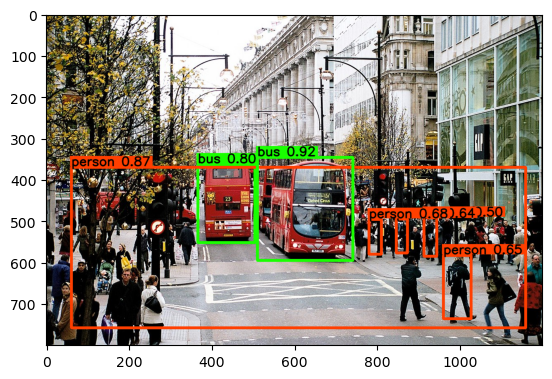

In [12]:
image_path = './images/street.jpg'

interpreter = tf.lite.Interpreter(model_path="../tflite_models/float32/ssdlite_mobilenet_v2.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# label
class_names = read_classes('./coco_labels.txt')
# Generate colors for drawing bounding boxes.
colors = generate_colors(class_names)
        
#image_object_detection(interpreter, colors)
result = image_object_detection(interpreter, colors, image_path)
plt.imshow(result)